# Part 0. Overview and introduction to the project

This notebook is my extra credit for Georgia Tech's OMSA CSE 6040 class. The purpose of this notebook is to apply a technique learned in the class, K means clustering, to a dataset that is aligned with how this algorithm may be used in organizational contexts. The example used here is in the marketing domain, as a way to segment customers. I'm seeking to answer 2 related questions here:

  1. Can the K-means algorithm be applied to a standard dataset like we may expect to have in a marketing analytics department at a company in a way that is interpretable and useful for marketing professionals?
  2. Can a dataset that might have been used for another marketing application (customer churn/cancellations prediction) be leveraged for this purpose along with that churn information to provide insights that marketing professional can act on?

Please note, my background is not in marketing. While I've done some reading on how this is applied in practice, I may make mistakes that do not align with best practices in the marketing domain. I welcome feedback on this topic, as well as feedback on how this algorithm was applied from a data practicioner standpoint, to improve my use of analytics methods applied to real world use cases.

The project will go through the following steps:

  1. Preview of the dataset, and some brief exploratory data analysis. This will not be as comprehensive as it might be in an organizational context, however it will cover the key parts needed for a reader to follow along and understand the decisions made later in the script.
  2. An brief review of the K-means algorithm and the application of it to this dataset. This will include data pre-processing as well as the implementation of the algorithm.
  3. An analysis of the clusters with respect to various features in the dataset.
  4. Discussion of results, next steps, and learnings.
  5. References used throughout the project.

I tried to write the explainations in this notebook to be accessible someone who is taking CSE 6040 as their first class in OMSA. As a result, if you have taken other classes here, you may find some of the explainations have more detail than is personally required to understand the decisions made. Feel free to skim those sections if your background knowledge is sufficient.

<b>Note: I recommend running this notebook by going to 'Kernel' and selecting 'Restart & Run all.'</b> This will run all the cells so output loads by the time you get there. It's also how I tested the code runs and timed it, so this will ensure the same user experience. If you run the cells sequentially, be careful not to re-run cells twice, as that may change the output. I've tried to write the code to be robust to that, but there may be cases where data is overwritten by this method.

<b>Second note: I use 'we' sometimes when I write more guide/tutorial style analyses, especially when interpreting output for a reader.</b> I did that a fair amount here. However, I did not work with anyone for this and did want to make sure that was noted as a writing style choice, not a project group choice.

# Part 1: Exploratory Data Analysis.

An exploratory data analysis at the beginning of an analytics project helps analytics practicioners become acquainted with their dataset, and make key model build decisions later. In the projects I've completed at work, this can be quite extensive. To aid readibility of this notebook, I've condensed it to the following sections due to their relevance in clustering:

  0. Brief overview of the data itself & data types
  1. Handling missing values
  2. Exploring distributions of features

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from IPython.display import Image

#### 1.0: Data overview

In [2]:
#read in data and create pandas dataframe
data = pd.read_csv('customer_churn_dataset-training-master_shortened.csv')
df = pd.DataFrame(data)
print(df.shape)
df.head()

(359998, 12)


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


This dataset is from kaggle and can be found here: https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset

The original dataset is set up for a classification task: churn prediction. However, many people have pointed out challenges with the data fields for that use, which is also part of what motivated me to try using it for clustering. Specifically, there are duplicate ids across the training and testing data, which presents a problem for measuring model performance in a supervised model build. Also, it is unclear what some of the fields mean, so I have done my best to infer that here.

While we learned in class that clustering and classification are very different tasks (unsupervised ML vs supervised ML), I do think the data can be re-purposed for clustering. There's information in here that may matter for things beyond just churn, and general customer groupings may raise structures in the data a supervised ML task may not. Additionally, this dataset has several numeric/quantitative predictors, which matter for clustering since you need to center and scale the data and use a distance measure like we did with K-means. That's difficult to do with categorical variables since they don't have that numeric interpretation. However for some reason, many of the datasets on Kaggle for marketing segmentation seem to be largely categorical in nature.

Just a note: to meet the data file size requirements for this project, I have removed several rows but retained all variables/features from the original. To do this, I just cut starting from the bottom of the dataset until the file was less than 20mb, just to be safe. The final dataset should be about ~18mb. The dataset here has about 80,000 less rows (less customers to consider), but still has all the following features:
  1. CustomerID: a unique identifer for each customer, starting at 2. We will probably want to cast this as an int.
  2. The customer's age, presumably in years.
  3. The customer's gender.
  3. The customer's tenure, presumably in months.
  4. The customer's usage frequency. It's unclear exactly how to interpret this column.
  5. The number of support calls a customer has made. We will probably want to cast this to an int so it's treated as such.
  6. The customer's subscription type in terms of the hypothetical tiers this hypothetical company offers. This is a categorical variable.
  7. The customer's contract length: billing annually, quarterly, or monthly. This is also a categorical variable.
  8. The customer's total spend, in dollars. I assume this is over their entire tenure with the company.
  9. The customer's last interaction. I am assuming this is measured in days since that last interaction.
  10. A binary variable representing whether the customer churned or not. Since we are not using this data for supervised learning, I will be dropping this until the end, when I do a very un-scientific comparison of where individuals in different clusters fall with respect to this variable.

The commands df.info() and df.describe() can also be used to get a preliminary look at data. It looks like there are no missing values given entries go from 0 to 359997 and the non-null count is 359997. This means only 1 row has null values, and we will investigate this further to confirm later on.

In [3]:
df.info() #This is what we can use to find the datatypes (Dtype column below)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359998 entries, 0 to 359997
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         359997 non-null  float64
 1   Age                359997 non-null  float64
 2   Gender             359997 non-null  object 
 3   Tenure             359997 non-null  float64
 4   Usage Frequency    359997 non-null  float64
 5   Support Calls      359997 non-null  float64
 6   Payment Delay      359997 non-null  float64
 7   Subscription Type  359997 non-null  object 
 8   Contract Length    359997 non-null  object 
 9   Total Spend        359997 non-null  float64
 10  Last Interaction   359997 non-null  float64
 11  Churn              359997 non-null  float64
dtypes: float64(9), object(3)
memory usage: 33.0+ MB


In [4]:
df.describe() #and just a bit more information about ranges, values, etc

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,359997.00000,359997.000000,359997.000000,359997.000000,359997.000000,359997.000000,359997.000000,359997.000000,359997.000000
mean,184501.27805,40.063170,31.013889,15.707134,4.058739,13.628666,605.122555,14.810365,0.694447
std,106311.76212,12.960045,17.287574,8.613939,3.169071,8.537596,250.025206,8.632159,0.460642
min,2.00000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,92536.00000,29.000000,16.000000,8.000000,1.000000,6.000000,411.000000,7.000000,0.000000
50%,184809.00000,40.000000,31.000000,16.000000,3.000000,13.000000,631.310000,14.000000,1.000000
75%,277112.00000,50.000000,46.000000,23.000000,7.000000,20.000000,815.000000,22.000000,1.000000
max,367112.00000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


#### 1.1: Handling Missing Values

In [5]:
#Check if any of the columns have missing values
df.isna().any()

CustomerID           True
Age                  True
Gender               True
Tenure               True
Usage Frequency      True
Support Calls        True
Payment Delay        True
Subscription Type    True
Contract Length      True
Total Spend          True
Last Interaction     True
Churn                True
dtype: bool

In [6]:
#view those rows
df[df.isna().any(axis=1)]

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It looks like there might be just one problematic row in the data. This would make sense if maybe there was some sort of collection error due to a person's data not getting recorded properly (a glitch in the recording software) or maybe that person asking for their data to be removed. Since it's only one row, it would be easy enough to just remove it.

In [7]:
df = df[~df.isna().any(axis=1)] #the tilde gets us rows where the data is not na on any of the rows
print(df.shape) #see now it's one less observation than before

(359997, 12)


While we're here, lets also change variable types to better represent the concepts they correspond to. Customer ID should be a categorical variable since it just represents the same thing as a name would. Number of support calls should be a whole number, so that'll be an integer.

In [8]:
df['CustomerID'] = df['CustomerID'].astype(object)
df['Support Calls'] = df['Support Calls'].astype(int)

From here on out, I'm going to work with the float columns only as we saw K-means is distance based, and categorical features can present challenges to that because they represent discrete levels a variable can take. For example, can we say a quarterly payment style is 3 times the magnitude of a monthly payment style? The amount of money paid may be, but that interpretation doesn't fully make sense when you just look at the payment plan type. In applied settings this means the work gets a bit more complicated if you need to include those variables, however for the purposes of this extra credit assignment I'm going to simplify the scope to just be our quantitative variables.

Some of these variables are numeric, but wouldn't make sense to cluster on either, like CustomerID. This is just a way of representing customers without using names, and customer 2 isn't twice the customer amount of customer 1. So that column will be removed, leaving us with the following numeric variables:
  1. Age
  2. Tenure
  3. Usage Frequency
  4. Support Calls
  5. Payment Delay
  6. Total Spend
  7. Last Interaction

In [9]:
df_floats = df.loc[:,['Age','Tenure','Usage Frequency','Support Calls','Payment Delay','Total Spend','Last Interaction']]
df_floats.head()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction
0,30.0,39.0,14.0,5,18.0,932.0,17.0
1,65.0,49.0,1.0,10,8.0,557.0,6.0
2,55.0,14.0,4.0,6,18.0,185.0,3.0
3,58.0,38.0,21.0,7,7.0,396.0,29.0
4,23.0,32.0,20.0,5,8.0,617.0,20.0


#### 1.2: Plots of feature distributions

I have a habit of doing my plots in a loop, so I'm going to do that here. For all the numeric variables, you can make the same plot (histogram) showing how the values of that variable are distributed across your dataset. It's also a good way to assess the range of your features, which as we saw in class matters for clustering because it is distance-based.

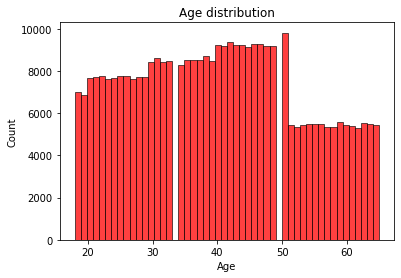

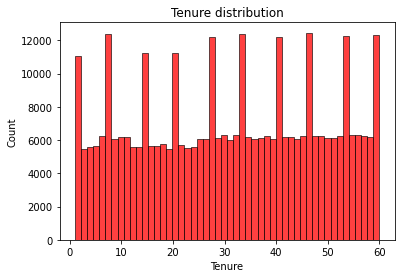

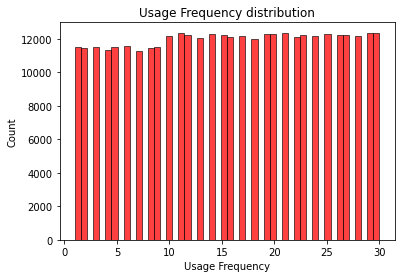

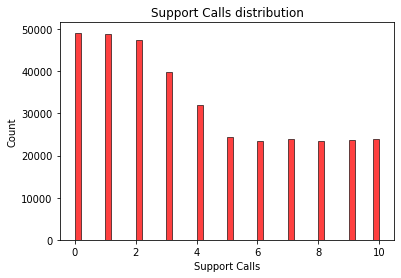

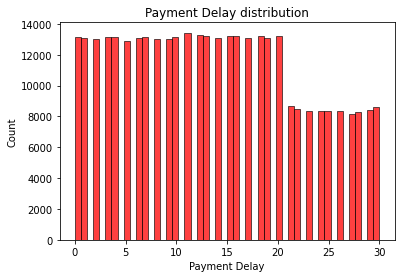

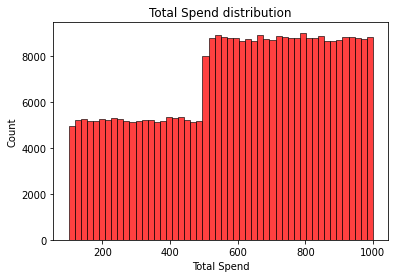

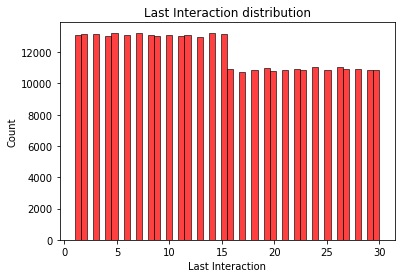

In [10]:
for col in df_floats.columns:
    sns.histplot(x=col, color='red', bins = 50, data=df_floats)
    plt.title(f'{col} distribution')
    plt.show()

We see some interesting distributions, including cases where not all possible values are present in the data. In other cases, it looks like there may be some clear dividing values in the data we may see later, such as a much larger group of customers who spend over $500 compared to those who spend less. There's also some interesting tenure patterns. This may just be a quirk of the dataset, or may have arisen from needing to reduce the data file size and data in the last 80,000 rows might have evened that out. 

Either way, there's not a whole lot we can do about it but it is good to note it in case we find odd results. Without more context into how the data were generated, there's also not anything we can use to know if these patterns are 'sensible' - for example pricing of items might explain that price distribution. In a business setting, asking stakeholders if there are reasons they can think of for these distributions might be a sensible step before beginning analyses, in case the reasons change how the analysis would be approached.

# Part 2: Data pre-processing and algorithm implementation

As we saw above, these features are on different scales. Some variables are in units of days/hours, others are dollar amounts, and some are counts. As a result, we will need to center and standardize them for use in clustering so that variability in range does not impact distance calculations. 

This section will proceed as follows:

  1. Centering and Scaling Data
  2. Running the K-means algorithm

#### 2.1: Center and scale data. 

Scikit-learn has a built-in method for doing this you can read about [here](https://scikit-learn.org/stable/modules/preprocessing.html). We'll be using it to center the data, and also make sure the variability of it is constant across features. While we only centered the data in class, having data that has different ranges even when centered around 0 could be problematic for clustering, so we will ensure we have a constant mean and variance across our dataset. The standard for this is a mean of 0 (centering) and a standard deviation of 1 (z-score scaling). The standard scaler does this by default.

In [11]:
#center and scale the data
scaler = preprocessing.StandardScaler()
df_floats_scaled = df_floats.copy(deep=True)
#https://stackoverflow.com/questions/24645153/pandas-dataframe-columns-scaling-with-sklearn - modify syntax to work with pandas dfs
df_floats_scaled[df_floats_scaled.columns] = scaler.fit_transform(df_floats_scaled[df_floats_scaled.columns])

#Sanity check: these means are the same as above when we run df.describe()
print(scaler.mean_)
print(scaler.var_)

#confirm it worked as expected
print(df_floats_scaled.mean(axis=0))
print(df_floats_scaled.std(axis=0))


[ 40.06316997  31.013889    15.70713367   4.05873938  13.62866635
 605.12255499  14.81036509]
[1.67962306e+02 2.98859392e+02 7.41997456e+01 1.00429834e+01
 7.28903393e+01 6.25124298e+04 7.45139654e+01]
Age                -5.558069e-17
Tenure             -6.631787e-17
Usage Frequency     7.579186e-17
Support Calls       7.831825e-17
Payment Delay      -2.400075e-17
Total Spend        -5.558069e-17
Last Interaction   -2.715875e-17
dtype: float64
Age                 1.000001
Tenure              1.000001
Usage Frequency     1.000001
Support Calls       1.000001
Payment Delay       1.000001
Total Spend         1.000001
Last Interaction    1.000001
dtype: float64


In [12]:
df_floats_scaled.head()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction
0,-0.776478,0.461957,-0.198183,0.297015,0.512011,1.307380,0.253661
1,1.924134,1.040408,-1.707367,1.874767,-0.659281,-0.192471,-1.020646
2,1.152531,-0.984170,-1.359094,0.612565,0.512011,-1.680323,-1.368184
3,1.384012,0.404112,0.614454,0.928116,-0.776410,-0.836407,1.643813
4,-1.316600,0.057042,0.498363,0.297015,-0.659281,0.047505,0.601199


#### 2.2 Run K-means

For K-means, when we ran the algorithm for class we chose a default number of clusters. Since I went less into detail on the algorithm used and brought in scikit-learn to implement Lloyd's algorithm, I'm going to go a bit into detail on something that we may also want to explore when using clustering in practice: the number of clusters to use. This is often not something we would be instructed to find, unless we had a requestor who had a reason for needing a certain number of clusters. Often, this is something that the analyst running clustering may either be expected to find or want to use data to find.

In K-means, there exists a way to find this using something called the ['elbow method'](https://www.geeksforgeeks.org/ml-determine-the-optimal-value-of-k-in-k-means-clustering/). This method looks at a range of possible cluster values, and finds the value that minimizes what is referred to as <b>inertia</b>. This is equivalent to the within cluster sum of squares we used when fitting Lloyd's algorithm in class, however it is utilized a bit differently. 

In class, we saw that in Lloyd's algorithm, the within cluster sum of squares was used to adjust the centers of a fixed number of clusters to a configuration that resulted in a low value of the sum of the squared distances from each point to its center. At some final configuration of cluster centers, we have a fixed overall within cluster sum of squares value that corresponds to  the within cluster sum of squares when summed up across all the clusters.

In the elbow method, we take the final within cluster sum of squares value we get from that particular number of clusters, and plot it against the number of clusters. The process for this is as follows:

  1. Set a range of possible cluster values to test out. This could be decided by domain knowledge, or just a range of what number of clusters would be feasible to work with.
  2. For each possible number of clusters, run Lloyd's algorithm to fit the K-means model, and return the final within cluster sum of squares value. This is very similar to the process we did in notebook 14, although we will use scikit learn here.
  3. Plot the value of each final within cluster sum of squares amount for each number of clusters, and look for a natural 'elbow' point. There will be a decreasing trend, because adding more clusters will allow for smaller, tightly-packed clusterings that should naturally have lower within cluster sums of squares to their center. However, we don't want to go too far and want to balance this with enough clusters to interpret meaningfully. Therefor, this elbow point is treated as the point of inflection where further decreases to within cluster sums of squares are not impactful enough to justify further increasing the number of clusters. If this is a bit tricky to follow, the visual plot below will hopefully clarify.

Since 1 cluster would be unhelpful, and 30 is a commonly-used number in statistics, I'm going to set 2 through 30 as our range of clusters. This is somewhat arbitrary, but it is also a workable set of possible values that will prevent this example from getting overly complext.

I've also explicitly set some parameters in the KMeans() model call:

  1. **n_clusters = cluster_val:** sets the number of clusters to test to the value in our range of clusters for that pass through the loop
  2. **init = 'random':** this is equivalent to our in-class implementation of a random initialization of n_clusters number of centers from the data
  3. **n_init = 1:** in Sklearn, you can re-fit the algorithm n_init times, and take the fit that resulted in the lowest within cluster sum of squares values. In class, we only did one fit rather than re-initializing some number of times, so I'm using 1 here too. Please note the documentation recommends setting this higher than 1, but in the intererest of time to run the code I'm only having it do 1 fit.
  4. **random state = 120976:** this is like setting a seed for reproducability. It *should* allow you to get the same results when you run this as when I ran it by using a specific randomization setting for things like the inital clusters, and n_init passes through the data. There's a possibility that isn't what happens if there are other sources of randomness in the algorithm though, so please be aware of that.
  5. **algorithm = 'lloyd':** this specifies use of Lloyd's algorithm, which is the one we implemented in class. This is the default, I'm setting it explicitly so it is clear that is the algorithm being used. This will follow the process we learned of initializing centers, grouping points into the centers based on distance, calculating within cluster sum of squares, re-positioning the center, and then updating until convergence is reached.

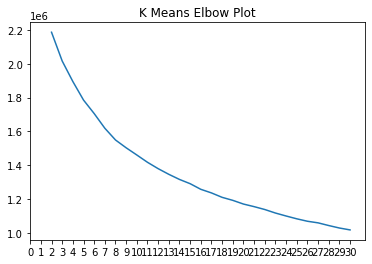

In [13]:
range_of_cluster_vals = range(2,31) #our range of values to try
wcss_vals = [] #to store them

#Documentation page: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#Reference for elbow method: https://www.geeksforgeeks.org/ml-determine-the-optimal-value-of-k-in-k-means-clustering/
#Reference for getting intertia: https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

for cluster_val in range_of_cluster_vals:

    #Fit model on centered & scaled data
    k_mean_model = KMeans(n_clusters=cluster_val, init='random', n_init=1, random_state=120976, algorithm='lloyd').fit(df_floats_scaled)

    #Get the final within cluster sum of squares value for the overall configuration from the model, add it to the list
    wcss_vals.append(k_mean_model.inertia_)

#Plot elbow plot
sns.lineplot(x=range_of_cluster_vals, y=wcss_vals)
plt.title('K Means Elbow Plot')
plt.xticks(range(0,31))
plt.show()

In [14]:
#quick dataframe to look at how wcss changes from cluster to cluster
wcss_df = pd.DataFrame()
wcss_df['num_clusters'] = list(range(2,31)) #the cluster values we tried
wcss_df['wcss value'] = wcss_vals #their within cluster sum of squares
wcss_df['differences1'] = wcss_df['wcss value'].diff() #change from wcss in row prior to next row. Shows us how much the wcss decreased from n to n+1 clusters
wcss_df['differences2'] = wcss_df['differences1'].diff() #difference of the difference - not sure if this makes sense but including it anyways
wcss_df.head(30) #just use this to display the whole df

,num_clusters,wcss value,differences1,differences2
0,2,2.185396e+06,NaN,NaN
1,3,2.015758e+06,-169638.669457,NaN
2,4,1.894620e+06,-121137.257926,48501.411531
3,5,1.785374e+06,-109246.427436,11890.830490
4,6,1.705646e+06,-79728.479860,29517.947576
5,7,1.619014e+06,-86631.328882,-6902.849022
6,8,1.549786e+06,-69228.361101,17402.967781
7,9,1.503642e+06,-46143.747210,23084.613891
8,10,1.461238e+06,-42403.902972,3739.844238
9,11,1.418150e+06,-43088.543013,-684.640041


We can look at the column differences1 above to see the amount of decrease of the within clusters sum of squares from num_clusters -1 to the current value of num_clusters. Unfortunately, between this and the graph there's not a clear elbow point here. Maybe there could be something interpreted as an elbow around num_clusters = 9, as we see the amount of decrease in wcss there is less than for num_clusters = 10. 

I tested out a few other methods aming to help choose the number of clusters, and they resulted in a really long run time for the code. Since we have a run time limit for this assignment, I opted to stick with this decision and go from here with 9 clusters. If you're doing clustering in any applied project settings, you might want to consider a few other methods such as [silhouette scores](https://www.geeksforgeeks.org/silhouette-algorithm-to-determine-the-optimal-value-of-k/) to measure how well we're creating distinct clusters, and the [gap statistic](https://www.geeksforgeeks.org/gap-statistics-for-optimal-number-of-cluster/) to consider how much better this clustering is compared to clustering on random data.


# Part 3: Review the results with respect to the known data labels.

This idea is based off of an exercise from another class in the OMSA degree, ISYE 6051. In that class, clustering was discussed with respect to the [iris dataset](), which also comes with category labels for the species of iris flower. In that exercise, we were also able to layer on those labels as a way of seeing if the clustering algorithm is finding a sensible structure. While this is often not possible in practice due to not having those labels, I did want to try and extend that idea here, mainly with respect to the features we have.

This section will proceed as follows:

  1. Get the cluster labels and attach them to the original dataframe
  2. Assessment of feature distributions by cluster
  3. Adding in the churn column from the original data just to see what that looks like

#### 3.1: Get the cluster labels from running K-Means with n_cluters = 9

In [15]:
#Initialize model with chosen value of 9 clusters
k_mean_model_9_clusters = KMeans(n_clusters=9, init='random', n_init=1, random_state=120976, algorithm='lloyd').fit(df_floats_scaled)

#get the labels, store in a list so easier to work with the values directly
labels = k_mean_model_9_clusters.labels_
labels = labels.tolist()
len(labels)

359997

Now we can put the labels on to the original dataframe. I'm putting it on the dataframe in its original scale for easier interpretation. Cluster labels also start at 0, and just to make it a bit easier to work with I'm going to add 1. These will keep the same clusters, but instead of having the range be 0 to 8, they will now be labeled 1 to 9.

In [16]:
df_floats['clusters'] = labels
print(df_floats['clusters'].unique())
df_floats['clusters'] = df_floats['clusters'] + 1
df_floats.head()

[3 6 8 4 1 0 2 7 5]


,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,clusters
0,30.0,39.0,14.0,5,18.0,932.0,17.0,4
1,65.0,49.0,1.0,10,8.0,557.0,6.0,7
2,55.0,14.0,4.0,6,18.0,185.0,3.0,7
3,58.0,38.0,21.0,7,7.0,396.0,29.0,7
4,23.0,32.0,20.0,5,8.0,617.0,20.0,9


#### 3.2: Examine the data contextualized by the clusters

This isn't the most scientific way of looking at the data, but since we're working with more than 2 features the data is going to be in more than 2 dimensions. As such, plots may offer limited visualization abilities, so I'm going to see if calculating a summary statistics table would be informative here. There will be one table for each cluster, and after I'll do some data wrangling to get a table of summary statistics per cluster, like we learned to do in the first half of the course with data re-formatting.

The code below looks somewhat complex, so I'll break it down:

  1. Filter the dataframe so that each pass through the loop, it's just looking at the rows assigned to that cluster (value = i)
  2. Apply df.describe() to that filtered dataframe, giving us summary statistics like the mean for that specific subset of the data
  3. To keep this analysis simple I'm just looking at the mean using .loc['mean'], but you could also look at the median, quartiles, etc.
  4. Converting this to a list to help with downstream processing
  5. Removing the last value because this comes from the cluster column, and the mean will just be that cluster label since that's the same for every observation in this filtered dataframe.
  
<b>Please note:</b> the first time I uploaded my code to Vocareum and re-ran it, I noticed the clusters changed. This may be due to differences in my personal computer's Python vs Vocareum. I've run it a few times in Vocareum since and I've not noticed changes, however just in case I'm also uploading a screenshot of the results I used to write the interpretation below.

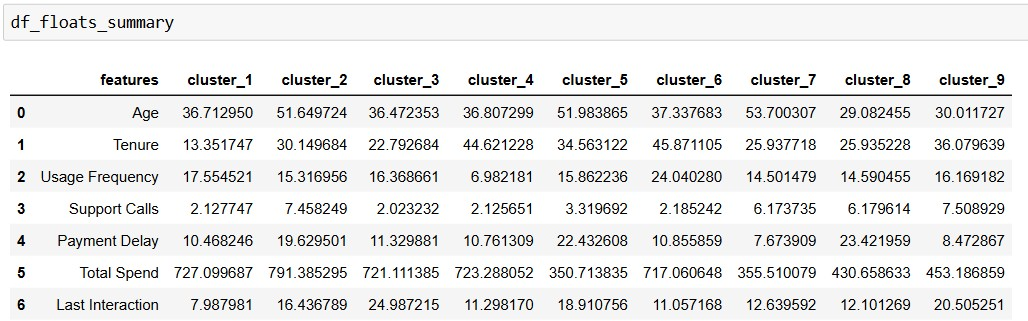

In [17]:
Image("final_run_clusters.jpg")

In [18]:
df_floats_summary = pd.DataFrame()
df_floats_summary['features'] = df_floats.columns.tolist()[:-1] #get the feature names
for i in range(1,df_floats['clusters'].max()+1):
    df_cluster_filtered = df_floats.loc[df_floats['clusters'] == i].describe().loc['mean'].tolist()[:-1]
    col_name = f'cluster_{i}'
    df_floats_summary[col_name] = df_cluster_filtered

In [19]:
df_floats_summary

,features,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,Age,36.712950,51.649724,36.472353,36.807299,51.983865,37.337683,53.700307,29.082455,30.011727
1,Tenure,13.351747,30.149684,22.792684,44.621228,34.563122,45.871105,25.937718,25.935228,36.079639
2,Usage Frequency,17.554521,15.316956,16.368661,6.982181,15.862236,24.040280,14.501479,14.590455,16.169182
3,Support Calls,2.127747,7.458249,2.023232,2.125651,3.319692,2.185242,6.173735,6.179614,7.508929
4,Payment Delay,10.468246,19.629501,11.329881,10.761309,22.432608,10.855859,7.673909,23.421959,8.472867
5,Total Spend,727.099687,791.385295,721.111385,723.288052,350.713835,717.060648,355.510079,430.658633,453.186859
6,Last Interaction,7.987981,16.436789,24.987215,11.298170,18.910756,11.057168,12.639592,12.101269,20.505251


There's a lot of features here, so interpretation can be a bit tricky and I may miss a few things.

Cluster 1 is individuals with an average age of about 36.7, and a tenure of around 13 months. They have low-moderate average payment delays, and a very high average spend. It's been about 8 days since their last interaction with the product, and they make a very low number of support calls per unit of time this is measured on. They have a moderate usage frequency. Since these individuals are high spenders and their average usage frequency could be higher, they may be good targets for a marketing campaign.

Cluster 2 is individuals with an average age of about 51.65, and an average tenure of about 30.15 months. They have a low-moderate usage frequency and they make on average quite a few more support calls than other users, however they also spend on average more than any other user. It's been about 16.5 days since their last interaction and they have an average payment delay on the higher end of the average values we see here. Since they spend a lot, this may be a group to target for retention, and perhaps it could be the topic of follow-up work at this company to understand why they make so many support calls.

Cluster 3 has individuals with an average age closer to cluster 1, and with a similar usage frequency, support call amount, payment delay amount, and total spend. However, they are higher tenure and on average have had a much longer amount of time since their last interaction. Due to this and because of that higher average spend, they may be a good group to focus on for an intervention, since they have a lower usage frequency.

Cluster 4 also has a similar average age, support call amount, payment delay, and average spend to clusters 1 and 3. Their time since last interaction is a bit closer to cluster 1 though, and their average tenure is much higher. Their usage frequency is also much lower. These may be individuials you want to target for retention efforts or to get them back to using this product since they have a high tenure and high average total spends, but it looks like they're using the product less.

I'm going to jump to cluster 6 now, due many similarities to cluster 4 except with respect to usage frequency. These look to be high tenure individuals with a higher spend on the product and also high use. From a company standpoint, these may not be individuals you need to do a whole lot with from a marketing standpoint, unless a separately-built churn model predicts individuals here are likely to churn. From what I see here, these seem to be people who like the product. It'd be interesting to see what the churn is in this cluster from the original data.

Cluster 5 has an average age of about 51.98 years, and an averrage tenure of 34.56 months. They have moderate usage frequency and make few support calls. They have one of the higher average payment delays, and lower average total spend. This group may be lower in priority for retention efforts due to these payment delays and spend, however if those customers are paying for the product eventually, due to their tenure and usage frequency they may still want to be retained.

Cluster 7 is similar to the Cluster 5 group on age, average spend, usage frequency and time since last interaction, however they have a lower average payment delay and as a result, if there is a targeted retention effort these individuals may take priority over cluster 5 due to that reason.

Clusters 8 and 9 are the last clusters and I'm going to compare them in a similar way to 5 and 7. They have similar average ages, and they are on the lower average age out of all the clusters (29-30). Cluster 9 has a bit higher of an average tenure than cluster 8 though. Their usage frequency looks the same and they make a similar number of support calls and have similar average spends. However, similar to what we saw with clusters 5 and 7, there's differences in average payment delays. Customers in cluster 9 have much lower average payment delays and due to this and their higher tenure, they may take priority for retention efforts. It's also been a bit longer since their last interaction, so a marketing department may want to entice them to come back and interact with their product, especially if that helps boost retention.

Since it might be interesting to see this with churn percentages layered in, I'll do that below. It wasn't a variable used to cluster on, and this should not change the clusters, it's just for descriptive purposes. I'm also going to store the cluster sizes using the count row from the filtered dataframes, since that may be informative too.

#### 3.3: Layer in Churn Information

In [20]:
#lets do this again with churn included, since we can
df_floats_with_churn = df_floats.copy(deep=True)
df_floats_with_churn['churn'] = df['Churn']
#df_floats_with_churn.info()

#for reasons I don't understand, churn is getting re-cast to categorical, so I'm going to change that just for purposes of this analysis
df_floats_with_churn['churn'] = df_floats_with_churn['churn'].astype(int)

In [21]:
#reorder so clusters is last and easier to remove
new_order = ['Age','Tenure','Usage Frequency','Support Calls','Payment Delay','Total Spend','Last Interaction','churn','clusters']
df_floats_with_churn = df_floats_with_churn[new_order]

df_floats_summary2 = pd.DataFrame()
df_floats_summary2['features'] = df_floats_with_churn.columns.tolist()[:-1] #get the feature names, remove clusters

#additionally, set up list to store cluster sizes
cluster_sizes = ['cluster_size']
for i in range(1,df_floats_with_churn['clusters'].max()+1):
    df_cluster_filtered = df_floats_with_churn.loc[df_floats_with_churn['clusters'] == i].describe().loc['mean'].tolist()[:-1] #drop row for cluster label mean
    cluster_sizes.append(df_floats_with_churn.loc[df_floats_with_churn['clusters'] == i].describe().loc['count'][0]) #I also want to see cluster sizes now
    col_name = f'cluster_{i}'
    df_floats_summary2[col_name] = df_cluster_filtered

In [22]:
#turn the cluster sizes into a new row so we can easily add it on to the df
new_row = pd.DataFrame(cluster_sizes).T
new_row.columns = df_floats_summary2.columns
new_row

,features,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,cluster_size,48009.0,37185.0,44507.0,47815.0,34893.0,45060.0,34472.0,36250.0,31806.0


In [23]:
#concatenate the new row with cluster sizes
new_df = pd.concat([df_floats_summary2, new_row], ignore_index=True)
new_df

,features,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,Age,36.71295,51.649724,36.472353,36.807299,51.983865,37.337683,53.700307,29.082455,30.011727
1,Tenure,13.351747,30.149684,22.792684,44.621228,34.563122,45.871105,25.937718,25.935228,36.079639
2,Usage Frequency,17.554521,15.316956,16.368661,6.982181,15.862236,24.04028,14.501479,14.590455,16.169182
3,Support Calls,2.127747,7.458249,2.023232,2.125651,3.319692,2.185242,6.173735,6.179614,7.508929
4,Payment Delay,10.468246,19.629501,11.329881,10.761309,22.432608,10.855859,7.673909,23.421959,8.472867
5,Total Spend,727.099687,791.385295,721.111385,723.288052,350.713835,717.060648,355.510079,430.658633,453.186859
6,Last Interaction,7.987981,16.436789,24.987215,11.29817,18.910756,11.057168,12.639592,12.101269,20.505251
7,churn,0.371972,0.987871,0.509291,0.390986,0.98332,0.394186,0.989557,0.996634,0.997673
8,cluster_size,48009.0,37185.0,44507.0,47815.0,34893.0,45060.0,34472.0,36250.0,31806.0


In [24]:
df_floats_with_churn['churn'].value_counts(normalize=True)

1    0.694447
0    0.305553
Name: churn, dtype: float64

This step would normally go in the exploratory data analysis, but since we didn't include churn as a feature in the K means model we haven't looked at the distribution of who churned vs didn't for this data. This is really weird, as the data card indicates 1 = churn, 0 = stayed with the company. This means over 2x as many people as stay with the company in this dataset end up leaving. This is really unusual for this sort of data and makes me wonder what other distributional oddities might be in there, so don't read too much into this. Even if I had the rows back that I deleted, it wouldn't make up for this odd discrepancy even if they were all churn = 0.

If this was a typical distribution, looking at the mean values of churn with the cluster profiles would be a really interesting analysis, because we have some really high churn clusters and some much lower churn clusters. In an applied setting, I assume we might use this to target retention interventions by looking at future customer profiles, seeing if they fit into these clusters, and then targeting them for retention if they're in a high-churn cluster with attributes the company wants to retain. Given that this entiere dataset is high churn though, I don't think that makes sense to read too much into here. We'd presumably have to run this again over time on our data, as customers' profiles will change as they stay with the company, making this maybe not the most feasible route in practice (ie where do individuals in clusters with lower average tenures go if they stay with the company a couple more years? Would it still make sense to put them in the cluster they're in when the analysis is run?)

# Part 4: Closing Thoughts


This dataset might have been a bit oddly-constructed, but in an applied setting where a company has actual data on their consumers, some version of this process could be applied. This answers our second question question: data from a churn use case could also be utilized in an unsupervised setting if the need arose. While fitting a churn model could be helpful for driving churn retention actions, this model may provide additional groupings and profiles with respect to attributes beyond churn, which could inform marketing campaign decisions in areas other than strictly retention.

Perhaps historical data on customer churn from a given period of time could be used to construct these clusters to create overall profiles, and then customers could be grouped into them by using the K-Means .predict() functionality either with the data itself or going forward. Obviously profiles may have to be updated as time goes on and people may need to be re-fit as their profiles change. I'm not sure how useful this would be to a marketing professional in general due to some of these considerations and the other unknowns that are part of this process (ie what to do if you don't find a clear optimal number of clusters), but this could be a start for a company looking to use their data for more effective marketing practices and creating customer groupings for targeting marketing and retention efforts.

As for the first question, there are many clustering algorithms besides K-means. This was a great algorithm to start with, and we did get results. A practicioner with more time and perhaps a team to bounce ideas off of may want to try additional quality metrics like those mentioned above to see if the clusters are truly good quality. A more comprehensive analysis could also branch into different clustering methods beyond the scope of this course to see if they provide additional insights. However I've read that K-means is well-liked for its ease of application and from this project it definitely seems like a great first pass at using data-driven methods to create customer groupings based on marketing data.

# 5.0: References:

1. Learnings from Georgia Tech's OMSA Course CSE 6040 on K-Means Clustering
2. [Kaggle's Customer Churn Datset](https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset/data?select=customer_churn_dataset-training-master.csv)
3. [Scikit-Learn's Documentation for K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) [and their StandardScaler](https://scikit-learn.org/stable/modules/preprocessing.html)
4. [StackOverflow post on ensuring data is scaled for each column](https://stackoverflow.com/questions/24645153/pandas-dataframe-columns-scaling-with-sklearn)
2. [GeeksForGeeks tutorial on clustering quality metrics](https://www.geeksforgeeks.org/ml-determine-the-optimal-value-of-k-in-k-means-clustering/) [and the elbow method in particular](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)